In [1280]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from myutils import (
    get_rolling_kelly, process_data, get_historical_var, calculate_daily_rf, get_cumulative_returns
)

In [1281]:
rebalance_interval = 10
var_confidence = 0.5
window = 400

In [1282]:
# 데이터 겟
kospi = pd.read_csv('KOSPI200.csv')
kospi = process_data(kospi)

# rf 추가
rf = pd.read_csv('rf_data.csv')
rf.columns = ['Date', 'rf']
rf = calculate_daily_rf(rf, 250)
kospi = kospi.join(rf)
kospi['rf'] = kospi['rf'].ffill()

In [1283]:
# VaR 계산
kospi_var = get_historical_var(kospi, window, var_confidence)

In [1284]:
# Kelly 계산
rolling_kelly = get_rolling_kelly(kospi_var)
kospi_var['kelly'] = rolling_kelly

In [1285]:
# 정해둔 시점에 대한 값만 겟
index_location = kospi_var.index.get_loc('01/08/2009')
kospi_target = kospi_var.iloc[index_location+1:]

### Kelly 지수 관련 시각화

In [1286]:
kospi_target['kelly'].describe()

count    3756.000000
mean        1.357031
std         4.783293
min        -9.057015
25%        -1.657733
50%         0.583098
75%         3.980352
max        18.025260
Name: kelly, dtype: float64

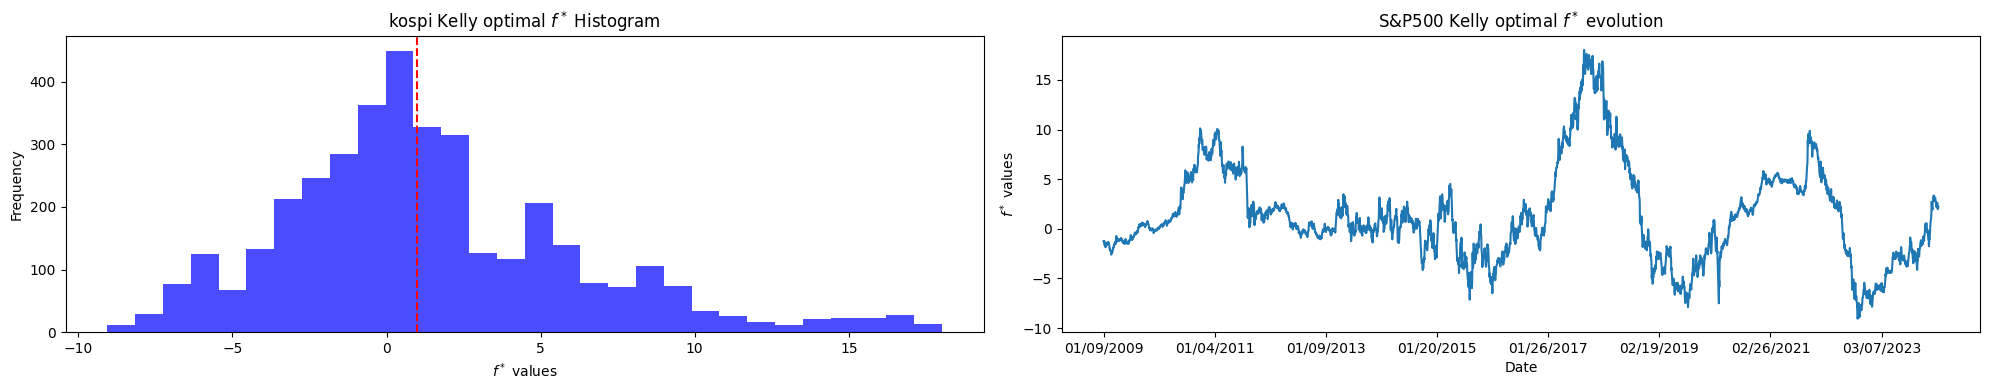

In [1287]:
# 서브플롯 설정
fig, ax = plt.subplots(ncols=2, figsize=(20, 4))

# Kospi Kelly optimal f* 히스토그램
ax[0].hist(kospi_target['kelly'], bins=30, color='blue', alpha=0.7)
ax[0].set_xlabel('$f^*$ values')
ax[0].set_ylabel('Frequency')
ax[0].set_title('kospi Kelly optimal $f^*$ Histogram')
ax[0].axvline(x=1, color='red', linestyle='--')

kospi_target['kelly'].plot(ax=ax[1])
ax[1].set_ylabel('$f^*$ values');
ax[1].set_title('S&P500 Kelly optimal $f^*$ evolution');

plt.savefig(f'result/kospi_kelly: rebalance_{str(rebalance_interval)}, var_{str(var_confidence)}, window_{str(window)}.png')

plt.tight_layout()
plt.show()

### 다시 캘리

In [1288]:
# kospi_target['kelly_ratio'] = kospi_target['kelly'] / 100
kospi_target['kelly_ratio'] = kospi_target['kelly']

/var/folders/yz/s1q6x0ws0mq8fpv7l4vlz9_c0000gn/T/ipykernel_53429/3025118912.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  kospi_target['kelly_ratio'] = kospi_target['kelly']


In [1289]:
kospi_zero_kelly = kospi_target.copy()
kospi_zero_kelly['kelly_ratio'] = kospi_zero_kelly['kelly_ratio'].apply(lambda x: x if x>0 else 0)

In [1290]:
def update_kelly(row):
    if row['VaR'] > row['Change']:
        return 0
    else:
        return row['kelly_ratio']
    
kospi_result_var_kelly = kospi_target.copy()
# apply 함수를 사용하여 kelly_ratio 업데이트
kospi_result_var_kelly['kelly_ratio'] = kospi_result_var_kelly.apply(lambda row: update_kelly(row), axis=1)

In [1291]:
rebalancing = rebalance_interval
kospi_result = get_cumulative_returns(kospi_target, rebalancing)
kospi_result_zero_kelly = get_cumulative_returns(kospi_zero_kelly, rebalancing)
kospi_result_var_kelly = get_cumulative_returns(kospi_result_var_kelly, rebalancing)

/Users/kimjihyo/Documents/GitHub/The-Kelly-Criterion/myutils.py:94: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'portfolio'] = portfolio
/Users/kimjihyo/Documents/GitHub/The-Kelly-Criterion/myutils.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'equity'] = equity
/Users/kimjihyo/Documents/GitHub/The-Kelly-Criterion/myutils.py:96: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

In [1292]:
kospi_result_var_kelly.to_csv(f'result/kospi_all_data: rebalance_{str(rebalance_interval)}, var_{str(var_confidence)}, window_{str(window)}.csv')

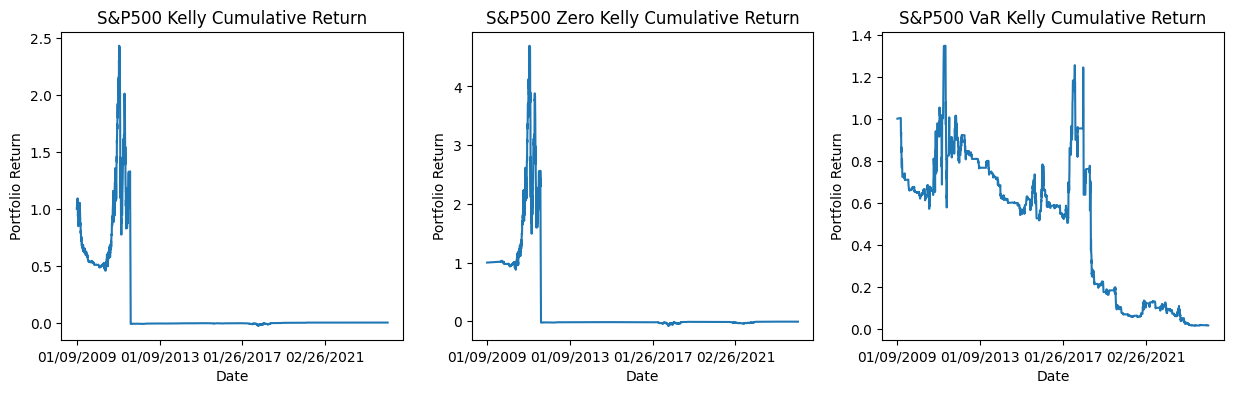

In [1293]:
fig, ax = plt.subplots(ncols=3, figsize=(15, 4))

kospi_result['portfolio'].plot(ax=ax[0])
ax[0].set_ylabel('Portfolio Return');
ax[0].set_title('S&P500 Kelly Cumulative Return');

kospi_result_zero_kelly['portfolio'].plot(ax=ax[1])
ax[1].set_ylabel('Portfolio Return');
ax[1].set_title('S&P500 Zero Kelly Cumulative Return');

kospi_result_var_kelly['portfolio'].plot(ax=ax[2])
ax[2].set_ylabel('Portfolio Return');
ax[2].set_title('S&P500 VaR Kelly Cumulative Return');


plt.savefig(f'result/kospi_Returns: rebalance_{str(rebalance_interval)}, var_{str(var_confidence)}, window_{str(window)}.png')